In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point

/Users/martine/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
listings = pd.read_csv('listings.csv')

In [3]:
#Gives the number of ligns and columns
listings.shape

(10032, 18)

In [4]:
listings.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,290701,"Central, big window, rear room with private bath.",1491565,David,NaN,Centrum-West,52.37561,4.90000,Private room,134.0,3,475,2024-12-03,3.05,2,207,38,0363 DF01 FBC0 496B 9730
1,291752,Cozy & large bohemian style room,1511330,Ton,NaN,Oud-Oost,52.35179,4.91082,Private room,155.0,3,271,2024-10-09,1.72,1,334,18,0363 6ACC BA1B 12A9 60C1
2,304082,"Private, quiet studio in the centre with terrace",276068,Mirre,NaN,Centrum-West,52.37191,4.89708,Entire home/apt,117.0,3,333,2024-11-06,2.15,1,247,51,0363 6C40 7413 ADD3 9AF8
3,304143,Unique Beautiful Houseboat (ship),1565319,Dick,NaN,Oud-Oost,52.36230,4.92028,Entire home/apt,NaN,28,50,2020-03-07,0.32,1,0,0,0363AF9644094CEBCE6B
4,306852,"SunShine, A Sunny Amsterdam Center Special",1141485,Gisèle And Simon,NaN,Centrum-Oost,52.35931,4.89844,Entire home/apt,NaN,4,32,2023-04-01,0.21,3,0,0,0363 33C3 B936 3911 FC42


In [5]:
listings.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm', 'license'],
      dtype='object')

In [6]:
listings.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group               float64
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                             float64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
number_of_reviews_ltm               int64
license                            object
dtype: object

In [7]:
print("n\Missing values per columns:")
print(listings.isnull().sum())

n\Missing values per columns:
id                                    0
name                                  0
host_id                               0
host_name                             0
neighbourhood_group               10032
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                              3742
minimum_nights                        0
number_of_reviews                     0
last_review                        1090
reviews_per_month                  1090
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
license                              94
dtype: int64


In [8]:
#Convert date column to date time
pd.to_datetime(listings['last_review'], errors ='coerce')

0       2024-12-03
1       2024-10-09
2       2024-11-06
3       2020-03-07
4       2023-04-01
           ...    
10027          NaT
10028          NaT
10029          NaT
10030          NaT
10031          NaT
Name: last_review, Length: 10032, dtype: datetime64[ns]

In [9]:
#Calculate the percentage of missing values
print("\n Percentage of missing values:")
perc = round(listings.isnull().sum() /len(listings), 2) *100

#Filter and display the columns with missing values
missing_columns = perc[perc > 0]
print(missing_columns)


 Percentage of missing values:
neighbourhood_group    100.0
price                   37.0
last_review             11.0
reviews_per_month       11.0
license                  1.0
dtype: float64


In [10]:
#Drop columns with >50% of missing values
listings = listings.drop(columns=['neighbourhood_group'])

In [11]:
listings['price'] = listings['price'].replace('[\€,]', '', regex = True).astype(float)

In [12]:
listings['price'] = listings['price'].fillna(listings['price'].median())

In [13]:
#Impute review related columns
review_columns = ['reviews_per_month', 'number_of_reviews_ltm']

for col in review_columns:
    listings[col] = listings[col].fillna(listings[col].median())

# Verify missing values after imputation
print("\nMissing values after imputation:")
print(listings.isnull().sum())


Missing values after imputation:
id                                   0
name                                 0
host_id                              0
host_name                            0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       1090
reviews_per_month                    0
calculated_host_listings_count       0
availability_365                     0
number_of_reviews_ltm                0
license                             94
dtype: int64


### Geospatial Spot

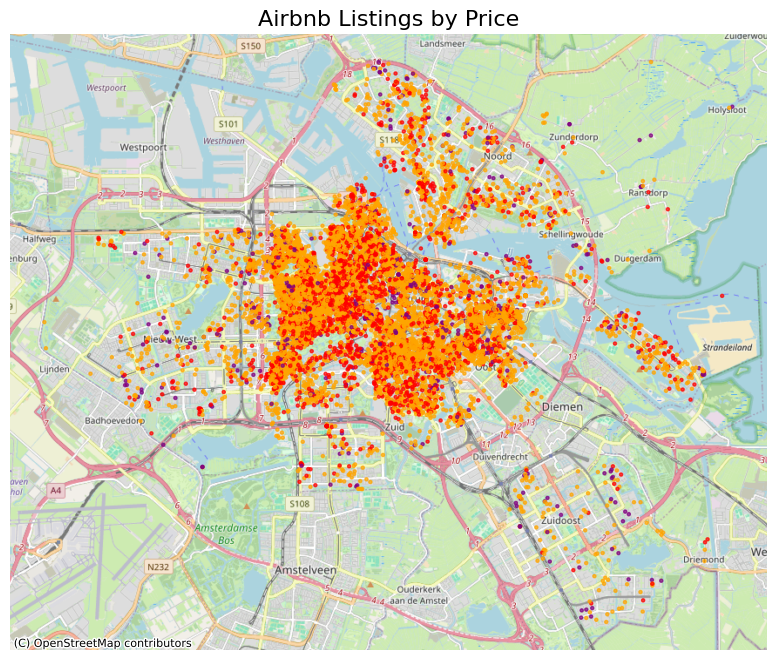

In [14]:
# Convert latitude and longitude into Point geometries
listings['geometry'] = [Point(xy) for xy in zip(listings['longitude'], listings['latitude'])]
gdf = gpd.GeoDataFrame(listings, geometry='geometry', crs="EPSG:4326").to_crs(epsg=3857)

# Assign colors based on price
gdf['color'] = gdf['price'].apply(lambda p: 'purple' if p < 100 else 'orange' if p < 250 else 'red')

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(ax=ax, marker='o', color=gdf['color'], markersize=5, alpha=0.7)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title("Airbnb Listings by Price", fontsize=16)
ax.set_axis_off()
plt.show()


### Univariative Analysis

In [15]:
listings.price.describe()

count    10032.000000
mean       239.337719
std        246.213936
min         10.000000
25%        189.000000
50%        210.000000
75%        246.000000
max      10000.000000
Name: price, dtype: float64

### Detecting outliers in the price column 

In [16]:
Q1 = listings['price'].quantile(0.25)
Q3 = listings['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = listings[(listings['price'] < lower_bound) | (listings['price'] > upper_bound)]
print(f"Number of outliers in 'price': {len(outliers)}")

print("\nOutlier prices:")
print(outliers['price'].describe())

#  Remove outliers
listings_cleaned = listings[(listings['price'] >= lower_bound) & (listings['price'] <= upper_bound)]


Number of outliers in 'price': 1954

Outlier prices:
count     1954.000000
mean       368.310645
std        531.842072
min         10.000000
25%         91.000000
50%        360.000000
75%        454.000000
max      10000.000000
Name: price, dtype: float64
